# Hybrid 2nd Order Mass Spring System w/ Collisions

This is Example 2.1 from the book "Impulsive and Hybrid Dynamical Systems: Stability, Dissipativity, and Control, Haddad, Chellaboina, Nersesov".

This is essentially a two-spring, two mass system, with "bumpers" of length L/2 on the right side of cart1 and the left side of cart2. If you play with "L", just imagine bumpers between the carts in the final gif. Right now the length 0.5, just accounts for the "width" of the box, so the bumpers are just the width of those cubes.

NOTE: Put together a diagram like page 25 of the book.

In [1]:
import numpy as np
from pydrake.common.containers import namedview
from pydrake.common.value import Value
from pydrake.math import RigidTransform, RotationMatrix
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import BasicVector, LeafSystem
from pydrake.trajectories import PiecewisePolynomial
from pydrake.all import LogVectorOutput
from pydrake.all import DiagramBuilder

from pydrake.systems.framework import WitnessFunctionDirection
from pydrake.systems.framework import UnrestrictedUpdateEvent
from pydrake.systems.framework import EventStatus

from pydrake.systems.analysis import SimulatorConfig, ApplySimulatorConfig

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Integration Schemes:

- For this example, we'll want to check what Integrations schemes are available, and try one that doesn't add too much energy to our system...

In [2]:
from pydrake.systems.analysis import GetIntegrationSchemes
from pydrake.systems.analysis import ResetIntegratorFromFlags

GetIntegrationSchemes()

# Later on we set it with: simconf = SimulatorConfig(accuracy=1e-10, max_step_size=0.001, integration_scheme='runge_kutta5')

['bogacki_shampine3',
 'explicit_euler',
 'implicit_euler',
 'radau1',
 'radau3',
 'runge_kutta2',
 'runge_kutta3',
 'runge_kutta5',
 'semi_explicit_euler',
 'velocity_implicit_euler']

In [3]:
class HybridSystem(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.

        self.name = "Example 2.2 from Impulsive and Hybrid Dynamical Systems"
        
        self.k1 = 1
        self.k2 = 0.1
        self.m1 = 2
        self.m2 = 1
        self.e = 0.8
        self.L = 0.5
        
        # Continuous State
        state_index = self.DeclareContinuousState(4)  
        self.DeclareStateOutputPort("y", state_index) 
    
        # https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=witnessfunction#pydrake.systems.framework.WitnessFunctio
        self.witness = self.MakeWitnessFunction(
            "witness", 
            WitnessFunctionDirection.kPositiveThenNonPositive, #kPositiveThenNonPositive, #kCrossesZero,
            self._guard,
            UnrestrictedUpdateEvent(self._reset)
        )
        
    def _guard(self, context):
        #t = context.get_time()
        x = context.get_continuous_state_vector()
        x1, x2, x3, x4 = x.GetAtIndex(0), x.GetAtIndex(1), x.GetAtIndex(2), x.GetAtIndex(3)
        L = self.L
        
        # See if their bumpers are touching...
        # easiest to just check absolute distance between cars...
        return L-(x1-x3)
        
        #return 666.0

    
    def _reset(self, context, event, state):
        x = context.get_continuous_state_vector()
        x1, x2, x3, x4 = x.GetAtIndex(0), x.GetAtIndex(1), x.GetAtIndex(2), x.GetAtIndex(3)
        m1,m2,k1,k2,e = self.m1, self.m2, self.k1, self.k2, self.e
        Δx1 = 0
        Δx2 = (-((1+e)*m2)/(m1+m2))*(x2-x4)
        Δx3 = 0
        Δx4 = (+((1+e)*m1)/(m1+m2))*(x2-x4)
        
        # We could just as well have returned just delx, but again, trying to make it explicit
        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            [x1+Δx1, 
             x2+Δx2,
             x3+Δx3,
             x4+Δx4]
        )
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector()
        #x = context.get_mutable_continuous_state().get_mutable_vector()
        x1, x2, x3, x4 = x.GetAtIndex(0), x.GetAtIndex(1), x.GetAtIndex(2), x.GetAtIndex(3)

        x1dot = x2
        x2dot = -((self.k1 + self.k2)/self.m1)*x1 + (self.k2/self.m1)*x3
        x3dot = x4
        x4dot = (self.k2/self.m2)*x1 - (self.k2/self.m2)*x3
        
        derivatives.get_mutable_vector().SetAtIndex(0, x1dot)
        derivatives.get_mutable_vector().SetAtIndex(1, x2dot)
        derivatives.get_mutable_vector().SetAtIndex(2, x3dot)
        derivatives.get_mutable_vector().SetAtIndex(3, x4dot)

    # This override is required (exactly as typed) anytime
    # you use a Witness function. It also must take "context",
    # and, of course, "self"
    def DoGetWitnessFunctions(self, context):
        return [self.witness]
             

In [4]:
# Construct an instance of this system and a context.
system = HybridSystem()
context = system.CreateDefaultContext()

builder = DiagramBuilder()
builder.AddSystem(system)
logger = LogVectorOutput(system.GetOutputPort('y'), builder)

builder.ExportOutput(system.GetOutputPort('y'))
diagram = builder.Build()

Simulating with ics:  [0.32, -0.8, 0.01, 0.6]


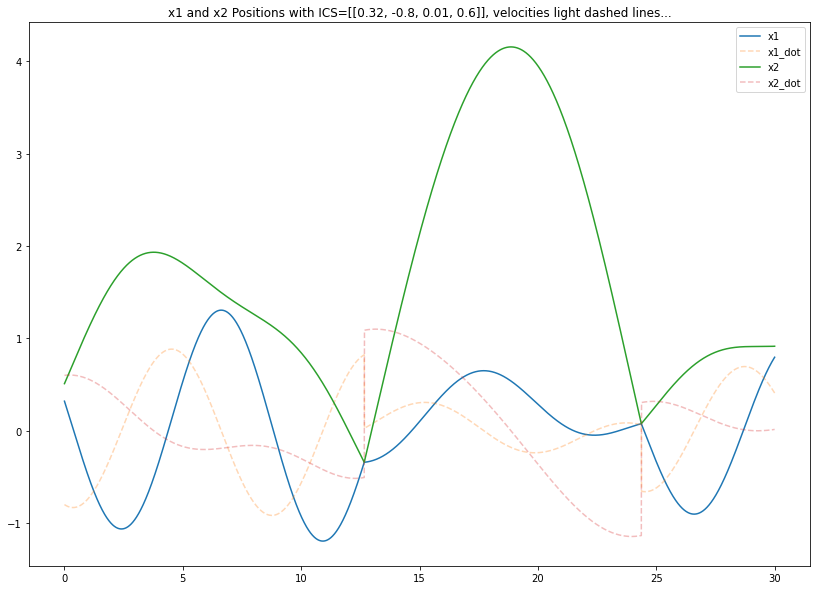

In [5]:
ics = [0.32, -0.8, 0.01, 0.6]

simulator = Simulator(diagram)

# We apply some sim_configs because this hybrid
# system is a little fussy...
simconf = SimulatorConfig(accuracy=1e-10, max_step_size=0.01, integration_scheme='runge_kutta5')
ApplySimulatorConfig(simconf, simulator)

sim_context = simulator.get_mutable_context()

# Set the initial conditions:
sim_context.SetTime(0)
sim_context.SetContinuousState(ics)

# If the "accuracy" is not set (tightened)
# Throws: RuntimeError: Integrator is not operating 
# in fixed step mode and accuracy is not set in the context.
sim_context.SetAccuracy(1e-10)

print("Simulating with ics: ", ics)

# Run the simulation forward.
simulator.AdvanceTo(30)#4.303)

log = logger.FindLog(sim_context)

# Specify the figure size
plt.figure(figsize=(14, 10))

plt.title("x1 and x2 Positions with ICS=["+str(ics)+"], velocities light dashed lines...")
plt.plot(log.sample_times(), log.data()[0], label="x1")
plt.plot(log.sample_times(), log.data()[1], "--", alpha=0.3, label="x1_dot")
plt.plot(log.sample_times(), log.data()[2]+system.L, label="x2")
plt.plot(log.sample_times(), log.data()[3], "--", alpha=0.3, label="x2_dot")
plt.legend()
plt.show()

# Quick Meshcat Viz, without all the system.Frameworks stuff.

- This is just a quick visualization in meshcat, setting the geometry directly. No multibody plant etc. We'll cover all that more in other tutorials.

***Quick helix generator for spring visualization***

In [6]:
# x direction only
def spring_verts(x1, x2, radius, yz_offset, resolution):
    yoff, zoff = yz_offset
    
    verts = np.array([[0, yoff, zoff]]).T
    for t in np.linspace(0, np.abs(x2-x1), resolution):
        x = t
        y = radius*np.cos((55/np.abs(x2-x1))*t) + yoff
        z = radius*np.sin((55/np.abs(x2-x1))*t) + zoff
        verts = np.hstack((verts, np.array([[x,y,z]]).T))

    verts[0, :] += x1
    
    return verts

### With Ipython you can view the Meshcat viewer in a Notebook, which is handy for debugging...

In [7]:
from pydrake.geometry import Box, Capsule
from pydrake.geometry import SceneGraph
from pydrake.geometry import StartMeshcat
from pydrake.geometry import Rgba
from IPython.display import IFrame

print("Click the link to open Meshcat viewer in the browser...")
meshcat = StartMeshcat()

address = meshcat.web_url()
print("Or, just view it here in the browser...")
display(IFrame(src=address, width='100%', height='500px'))

ics = [0.32, -0.8, 0.01, 0.6]

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()
sim_context.SetTime(0)
sim_context.SetContinuousState(ics)
sim_context.SetAccuracy(1e-10)      #<--- hybrid model needs this.

# width, depth, height
box1 = Box(1, 1, 1)
box2 = Box(1, 1, 1)

springcolor = Rgba(r=0.0, g=0.0, b=0.3, a=1.0)
meshcat.SetLine("spring1", spring_verts(-1, 0.5, 0.125, [0.0, 0.0], 100), line_width=1.0, rgba=springcolor)
meshcat.SetLine("spring2", spring_verts(0.5, 0.5+system.L, 0.125, [0.0, 0.0], 100), line_width=1.0, rgba=springcolor)

meshcat.SetObject("box1", box1, Rgba(r=0.9, g=0.3, b=0.3, a=1.0))
meshcat.SetObject("box2", box2, Rgba(r=0.9, g=0.7, b=0.3, a=1.0))

box1_pos = RigidTransform()
box2_pos = RigidTransform()

box1_initial = box1_pos
box2_initial = box2_pos

meshcat.SetTransform("box1", box1_initial)
meshcat.SetTransform("box2", box2_initial)

print("Use the slider in the MeshCat controls to apply elbow torque.")
print("Press 'Stop Simulation' in MeshCat to continue.")
meshcat.AddButton("Stop Simulation")

while meshcat.GetButtonClicks("Stop Simulation") < 1:
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.025)
    
    x = sim_context.get_continuous_state_vector()
    x1_pos, x2_pos = x.GetAtIndex(0), x.GetAtIndex(2)
    
    box1_pos.set_translation(np.array([x1_pos - 0.5, 0, 0]))
    box2_pos.set_translation(np.array([x2_pos + 0.5 + system.L, 0, 0]))
    
    meshcat.SetTransform("box1", box1_pos)
    meshcat.SetTransform("box2", box2_pos)
    
    meshcat.SetLine("spring2", spring_verts(x1_pos -0.5, 
                                            x2_pos+0.5+system.L, 
                                            0.125, 
                                            [0.0, 0.0], 
                                            100), 
                    line_width=1.0, rgba=springcolor)
    
    meshcat.SetLine("spring1", spring_verts(-2.25, x1_pos -0.5, 0.125, [0.0, 0.0], 100), line_width=1.0, rgba=springcolor)


INFO:drake:Meshcat listening for connections at http://localhost:7001


Click the link to open Meshcat viewer in the browser...
Or, just view it here in the browser...


Use the slider in the MeshCat controls to apply elbow torque.
Press 'Stop Simulation' in MeshCat to continue.
